In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_breusch_godfrey, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from refractive_index import ciddor
from datetime import datetime, timedelta
import os

# color scheme
PUB_GRAY = '#cecece'
PUB_PURPLE = '#a559aa'
PUB_TEAL = '#59a89c'
PUB_GOLD = '#f0c571'
PUB_RED = '#e02b35'
PUB_BLUE = '#082a54'


def check_data_quality(df):
    """
    Comprehensive data quality assessment
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataset to check
    """
    print("Missing Value Check:")
    print(df.isnull().sum())
    
    print("\nDescriptive Statistics:")
    print(df.describe())
    
def perform_regression(df, block_length=None, n_bootstrap=2000):
    """
    Enhanced regression analysis with HAC standard errors, block bootstrap, and error-in-variables analysis
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataset with environmental variables and refractive index
    block_length : int, optional
        Block length for bootstrap (auto-calculated if None)
    n_bootstrap : int
        Number of bootstrap iterations
        
    Returns:
    --------
    dict
        Comprehensive regression results including models, parameters, and diagnostics
    """
    print("Performing enhanced regression analysis...")
    
    # Prepare regression variables
    X = df[['temperature', 'humidity', 'pressure']].copy()
    X['pressure'] = X['pressure'] * 100  # Convert to Pascals
    y = df['n_1762']
    
    # Add constant term
    X = sm.add_constant(X)
    X.columns = ['const', 'temperature', 'humidity', 'pressure']
    
    # 1. Basic OLS regression
    print("\n1. Basic OLS Results:")
    model_ols = sm.OLS(y, X).fit()
    print(model_ols.summary())
    
    # Durbin-Watson statistic for autocorrelation
    dw_statistic = sm.stats.stattools.durbin_watson(model_ols.resid)
    print(f"\nDurbin-Watson Statistic: {dw_statistic:.3f}")
    
    # 2. HAC (Newey-West) standard errors
    print("\n2. HAC (Newey-West) Standard Errors:")
    nlags = int(4 * (len(y)/100)**(2/9))
    model_hac = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': nlags})
    print(f"Lags used: {nlags}")
    print(model_hac.summary())
    
    # 3. Block bootstrap for robust inference
    print("\n3. Performing Block Bootstrap...")
    if block_length is None:
        acf = sm.tsa.stattools.acf(model_ols.resid, nlags=40, fft=True)
        tau_int = 1 + 2 * np.sum(acf[1:]**2)
        block_length = max(10, int(4 * tau_int))
        print(f"Estimated integrated autocorrelation time: {tau_int:.2f}")
    
    print(f"Block length used: {block_length}")
    
    data = pd.concat([y, X], axis=1)
    
    def regression_func(data):
        """Bootstrap regression function"""
        y_bs = data.iloc[:, 0]
        X_bs = data.iloc[:, 1:]
        return sm.OLS(y_bs, X_bs).fit().params
    
    # Efficient block bootstrap implementation
    bootstrap_results = []
    n = len(data)
    
    for i in range(n_bootstrap):
        if i % 500 == 0:
            print(f"Completed {i}/{n_bootstrap} bootstrap iterations")
        
        # Manual block sampling
        start_idx = np.random.randint(0, n - block_length + 1)
        indices = list(range(start_idx, start_idx + block_length))
        
        # Handle boundary cases
        if start_idx + block_length > n:
            indices = list(range(start_idx, n)) + list(range(0, block_length - (n - start_idx)))
        
        sample_data = data.iloc[indices]
        params = regression_func(sample_data)
        bootstrap_results.append(params)
    
    bootstrap_params = np.array(bootstrap_results)
    
    # Calculate bootstrap confidence intervals
    alpha = 0.05
    bootstrap_ci_95 = np.percentile(bootstrap_params, [100*alpha/2, 100*(1-alpha/2)], axis=0)
    bootstrap_ci_68 = np.percentile(bootstrap_params, [16, 84], axis=0)
    
    # 4. Error-in-variables Monte Carlo simulation
    print("\n4. Performing Error-in-Variables Monte Carlo Simulation...")
    n_simulations = 2000
    eiv_results = []
    
    sensor_errors = {
        'temperature': 0.5,    # °C
        'humidity': 3.0,       # %
        'pressure': 12.0       # Pa
    }
    
    # Pre-compute systematic offsets for efficiency
    systematic_offsets = {col: np.random.uniform(-error, error, n_simulations) 
                         for col, error in sensor_errors.items()}
    
    for i in range(n_simulations):
        if i % 500 == 0:
            print(f"Completed {i}/{n_simulations} EIV simulations")
        
        X_perturbed = X.copy()
        for col in sensor_errors:
            if col in X_perturbed.columns:
                systematic_offset = systematic_offsets[col][i]
                random_noise = np.random.normal(0, sensor_errors[col]/3, len(X))
                X_perturbed[col] = X[col] + systematic_offset + random_noise
        
        model_eiv = sm.OLS(y, X_perturbed).fit()
        eiv_results.append(model_eiv.params)
    
    eiv_params = np.array(eiv_results)
    eiv_ci = np.percentile(eiv_params, [16, 84], axis=0)
    
    # 5. Prais-Winsten estimation for autocorrelation correction
    print("\n5. Using Prais-Winsten Estimation...")
    try:
        # Estimate AR(1) coefficient
        resid = model_ols.resid
        rho = np.corrcoef(resid[1:], resid[:-1])[0, 1]
        
        # Prais-Winsten transformation
        y_transformed = y.copy()
        X_transformed = X.copy()
        
        # Transform first observation
        y_transformed.iloc[0] = y.iloc[0] * np.sqrt(1 - rho**2)
        X_transformed.iloc[0] = X.iloc[0] * np.sqrt(1 - rho**2)
        
        # Transform remaining observations
        for t in range(1, len(y)):
            y_transformed.iloc[t] = y.iloc[t] - rho * y.iloc[t-1]
            X_transformed.iloc[t] = X.iloc[t] - rho * X.iloc[t-1]
        
        model_prais = sm.OLS(y_transformed, X_transformed).fit()
        print("Prais-Winsten Estimation Results:")
        print(model_prais.summary())
        
        gls_coefs = model_prais.params
        gls_success = True
        
    except Exception as e:
        print(f"Prais-Winsten estimation failed: {e}")
        gls_coefs = model_ols.params
        gls_success = False
    
    # 6. Create comprehensive results summary
    print("\n6. Comprehensive Results Summary:")
    results_summary = pd.DataFrame({
        'Variable': X.columns,
        'OLS_Coefficient': model_ols.params,
        'OLS_SE': model_ols.bse,
        'HAC_SE': model_hac.bse,
        # 'Bootstrap_68_CI_Lower': bootstrap_ci_68[0],
        # 'Bootstrap_68_CI_Upper': bootstrap_ci_68[1],
        'Bootstrap_95_CI_Lower': bootstrap_ci_95[0],
        'Bootstrap_95_CI_Upper': bootstrap_ci_95[1],
        'EIV_Systematic_Error': np.std(eiv_params, axis=0),
        'GLS_Approx_Coefficient': gls_coefs
    })
    
    print(results_summary.round(12))
    
    # 7. Additional diagnostic tests
    print("\n7. Additional Diagnostics:")
    
    # Breusch-Godfrey autocorrelation test
    try:
        bg_test = acorr_breusch_godfrey(model_ols, nlags=5)
        print(f"Breusch-Godfrey Test (lag=5): LM={bg_test[0]:.3f}, p-value={bg_test[1]:.3f}")
    except:
        print("Breusch-Godfrey test failed")
    
    # Heteroscedasticity test
    try:
        bp_test = het_breuschpagan(model_ols.resid, model_ols.model.exog)
        print(f"Breusch-Pagan Heteroscedasticity Test: LM={bp_test[0]:.3f}, p-value={bp_test[1]:.3f}")
    except:
        print("Breusch-Pagan test failed")
    
    # Variance Inflation Factor for multicollinearity
    try:
        vif_data = pd.DataFrame()
        vif_data["Variable"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        print("\nVariance Inflation Factors (VIF):")
        print(vif_data)
    except:
        print("VIF calculation failed")
    
    return {
        'ols_model': model_ols,
        'hac_model': model_hac,
        'bootstrap_params': bootstrap_params,
        'bootstrap_ci_95': bootstrap_ci_95,
        # 'bootstrap_ci_68': bootstrap_ci_68,
        'eiv_params': eiv_params,
        'eiv_ci': eiv_ci,
        'gls_coefs': gls_coefs,
        'gls_success': gls_success,
        'results_summary': results_summary,
        'dw_statistic': dw_statistic,
        'rho_estimate': rho if 'rho' in locals() else None
    }

def plot_diagnostics(results, df):
    """
    Diagnostic plots for regression analysis
    
    Parameters:
    -----------
    results : dict
        Regression results from perform_regression
    df : pandas.DataFrame
        Original dataset
    """
    model_ols = results['ols_model']
    
    # Create 2x2 subplot layout
    fig, axes = plt.subplots(2, 2, figsize=(8.6, 6))
    fig.suptitle('Regression Diagnostics', fontsize=16, fontweight='bold')
    
    # 1. Residual autocorrelation function
    sm.graphics.tsa.plot_acf(model_ols.resid, lags=40, alpha=0.05, ax=axes[0,0])
    axes[0,0].set_title('Residual Autocorrelation', fontsize=12)
    axes[0,0].set_xlabel('Lag')
    axes[0,0].set_ylabel('Autocorrelation')
    axes[0,0].set_ylim(0,1)
    
    # 2. Residual partial autocorrelation function
    sm.graphics.tsa.plot_pacf(model_ols.resid, lags=40, alpha=0.05, ax=axes[0,1])
    axes[0,1].set_title('Residual Partial Autocorrelation', fontsize=12)
    axes[0,1].set_xlabel('Lag')
    axes[0,1].set_ylabel('Partial Autocorrelation')
    axes[0,1].set_ylim(0,1)
    
    # 3. Standard error comparison
    summary = results['results_summary']
    variables = summary['Variable'][1:].values  # Exclude constant
    ols_errors = summary['OLS_SE'][1:].values
    hac_errors = summary['HAC_SE'][1:].values
    
    x_pos = np.arange(len(variables))
    width = 0.35
    
    axes[1,0].bar(x_pos - width/2, ols_errors, width, label='OLS SE', alpha=0.7, 
                 color='steelblue', edgecolor='black', linewidth=0.5)
    axes[1,0].bar(x_pos + width/2, hac_errors, width, label='HAC SE', alpha=0.7,
                 color='lightcoral', edgecolor='black', linewidth=0.5)
    axes[1,0].set_xlabel('Variable')
    axes[1,0].set_ylabel('Standard Error')
    axes[1,0].set_title('Standard Error Comparison', fontsize=12)
    axes[1,0].set_xticks(x_pos)
    axes[1,0].set_xticklabels(variables, rotation=45, ha='right')
    axes[1,0].legend()
    
    # 4. Residual distribution
    residuals = model_ols.resid
    axes[1,1].hist(residuals, bins=30, alpha=0.7, color='lightgreen', 
                  edgecolor='black', linewidth=0.5)
    axes[1,1].axvline(x=0, color='red', linestyle='--', linewidth=1)
    axes[1,1].set_xlabel('Residual Value')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Residual Distribution', fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig('../figures/refractive_index/diagnostics.png', dpi=600, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.show()
    
    # Additional time series plots
    fig2, (ax1, ax2) = plt.subplots(2, 1, figsize=(8.6, 6))
    
    # Residual time series
    ax1.plot(df.index, model_ols.resid, 'o-', markersize=2, linewidth=0.5, 
            color='navy', alpha=0.7)
    ax1.axhline(y=0, color='red', linestyle='--', linewidth=1)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Residuals')
    ax1.set_title('Residual Time Series', fontsize=12)
    
    # Bootstrap coefficient distributions
    bootstrap_params = results['bootstrap_params']
    colors = ['steelblue', 'lightcoral', 'lightgreen']
    for i, var in enumerate(variables):
        ax2.hist(bootstrap_params[:, i+1], alpha=0.7, label=var, bins=30,
                color=colors[i], edgecolor='black', linewidth=0.5)
    ax2.set_xlabel('Coefficient Value')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Bootstrap Coefficient Distributions', fontsize=12)
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('../figures/refractive_index/timeseries_bootstrap.png', dpi=600, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.show()

def plot_mean_with_errorbar(df, bin_size=0.3, figsize=(8.6, 6)):
    """
    Environmental dependence plot with error bars
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataset with environmental variables and refractive index
    bin_size : float
        Bin size for grouping environmental variables
    figsize : tuple
        Figure dimensions
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle('Environmental Dependence of Refractive Index', fontsize=16, fontweight='bold')
    
    # Create bins for environmental variables
    df['temp_bin'] = (df['temperature'] // bin_size) * bin_size
    df['humidity_bin'] = (df['humidity'] // bin_size) * bin_size
    df['pressure_bin'] = (df['pressure'] // bin_size) * bin_size
    
    colors = ['steelblue', 'lightcoral', 'lightgreen']
    titles = ['Temperature', 'Humidity', 'Pressure']
    xlabels = ['Temperature (°C)', 'Humidity (%)', 'Pressure (hPa)']
    
    for i, (var, ax, color, title, xlabel) in enumerate(zip(
        ['temp_bin', 'humidity_bin', 'pressure_bin'], axes, colors, titles, xlabels)):
        
        group = df.groupby(var)['n_1762'].agg(['mean', 'std', 'count'])
        group = group[group['count'] > 5]  # Minimum sample size
        
        # Calculate refractive index offset (n-1) × 10^4
        y_values = (group['mean'] - 1) * 1e4
        y_errors = group['std'] * 1e4
        
        ax.errorbar(group.index, y_values, yerr=y_errors, fmt='o', 
                   color=color, markersize=4, capsize=3, linewidth=1,
                   ecolor=color, elinewidth=1, alpha=0.8)
        
        ax.set_xlabel(xlabel)
        ax.set_title(title, fontsize=12)
        if i == 0:
            ax.set_ylabel(r'Refractive Index $(n - 1) \times 10^{4}$')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.savefig('../figures/refractive_index/environmental_dependence.png', dpi=600, 
                bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()

def visualize_data(df):
    """
    Data visualization
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataset to visualize
    """
    # Variable distributions
    fig, axes = plt.subplots(2, 2, figsize=(8.6, 6))
    fig.suptitle('Variable Distributions', fontsize=16, fontweight='bold')
    
    variables = ['n_1762', 'temperature', 'humidity', 'pressure']
    titles = ['Refractive Index', 'Temperature', 'Humidity', 'Pressure']
    colors = ['steelblue', 'lightcoral', 'lightgreen', 'goldenrod']
    
    for i, (var, title, color) in enumerate(zip(variables, titles, colors)):
        row, col = i // 2, i % 2
        axes[row, col].hist(df[var], bins=30, alpha=0.7, color=color,
                          edgecolor='black', linewidth=0.5)
        axes[row, col].set_xlabel(title)
        axes[row, col].set_ylabel('Frequency')
        axes[row, col].set_title(title + ' Distribution', fontsize=10)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig('../figures/refractive_index/distributions.png', dpi=600, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.show()
    
    # Correlation matrix
    variables = ['n_1762', 'temperature', 'humidity', 'pressure']
    df_plot = df[variables].copy()
    df_plot.columns = ['Refractive\nIndex', 'Temperature', 'Humidity', 'Pressure']
    
    corr_matrix = df_plot.corr()
    
    fig, ax = plt.subplots(figsize=(8.6, 6))
    im = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
    
    # Add correlation values
    for i in range(len(corr_matrix)):
        for j in range(len(corr_matrix)):
            ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                   ha='center', va='center', fontsize=10,
                   color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black')
    
    ax.set_xticks(range(len(corr_matrix)))
    ax.set_yticks(range(len(corr_matrix)))
    ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
    ax.set_yticklabels(corr_matrix.columns)
    ax.set_title('Correlation Matrix', fontsize=14)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Correlation Coefficient', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.savefig('../figures/refractive_index/correlation_matrix.png', dpi=600, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.show()

def create_uncertainty_budget_table(results):
    """
    Uncertainty budget table
    
    Parameters:
    -----------
    results : dict
        Regression results from perform_regression
        
    Returns:
    --------
    pandas.DataFrame
        Uncertainty budget table
    """
    summary = results['results_summary']
    
    uncertainty_budget = pd.DataFrame({
        'Uncertainty Source': [
            'Finite sample & serial correlation',
            'Temperature sensor calibration',
            'Humidity sensor calibration', 
            'Pressure sensor calibration',
            '780 nm frequency reference',
            '1762 nm frequency reference',
            'Interferometer non-linearity',
            'Spatial/temporal mismatch'
        ],
        'Affected Parameter': [
            'All coefficients',
            r'$\alpha_T$',
            r'$\alpha_H$', 
            r'$\alpha_P$',
            'Constant term',
            'Constant term',
            'All coefficients',
            'Residual variance'
        ],
        'Estimation Method': [
            'HAC + Block Bootstrap',
            'EIV Monte Carlo',
            'EIV Monte Carlo',
            'EIV Monte Carlo', 
            'Analytical propagation',
            'Analytical propagation',
            'Upper-bound estimate',
            'Residual analysis'
        ],
        'Magnitude (1σ)': [
            f"{np.mean(summary['HAC_SE'][1:].values):.2e}",
            f"{summary[summary['Variable'] == 'temperature']['EIV_Systematic_Error'].values[0]:.2e}",
            f"{summary[summary['Variable'] == 'humidity']['EIV_Systematic_Error'].values[0]:.2e}",
            f"{summary[summary['Variable'] == 'pressure']['EIV_Systematic_Error'].values[0]:.2e}",
            '<1e-9',
            'Negligible',
            'Negligible', 
            f"{results['ols_model'].resid.std():.2e}"
        ]
    })
    
    print("Uncertainty Budget Analysis")
    print("=" * 80)
    print(uncertainty_budget.to_string(index=False, justify='left'))
    print("=" * 80)
    
    return uncertainty_budget

def main_analysis(df):
    """
    Main function for analysis pipeline
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Combined dataset for analysis
        
    Returns:
    --------
    tuple
        (regression_results, uncertainty_budget)
    """
    print("\nPerforming Analysis...")
    
    # Data quality assessment
    check_data_quality(df)
    
    # data visualizations
    visualize_data(df)
    plot_mean_with_errorbar(df)
    
    # Enhanced regression analysis
    results = perform_regression(df, n_bootstrap=2000)
    
    # diagnostics
    plot_diagnostics(results, df)
    
    # Uncertainty budget table
    uncertainty_budget = create_uncertainty_budget_table(results)
    
    print("\nAnalysis completed!")
    print("All figures saved.")
    
    return results, uncertainty_budget


Performing Analysis...
Missing Value Check:
laser_offset        0
humidity            0
temperature         0
pressure            0
counts_ratio        0
n_1762              0
temp_bin        10954
humidity_bin    10954
pressure_bin    10954
dtype: int64

Descriptive Statistics:
       laser_offset      humidity   temperature      pressure  counts_ratio  \
count  89106.000000  89106.000000  89106.000000  89106.000000  8.910600e+04   
mean    -130.024144     30.037568     28.297880    986.237660  2.258487e+00   
std       37.788554      4.111705      3.921904      5.023723  5.018326e-07   
min     -199.452598     18.698722     17.507900    964.605044  2.258486e+00   
25%     -154.206441     26.995857     27.221086    983.962774  2.258487e+00   
50%     -131.307434     28.879478     28.848635    987.379241  2.258488e+00   
75%     -108.403682     33.212453     30.996427    989.525724  2.258488e+00   
max       -2.969851     45.320557     34.622549   1002.293666  2.258488e+00   

       

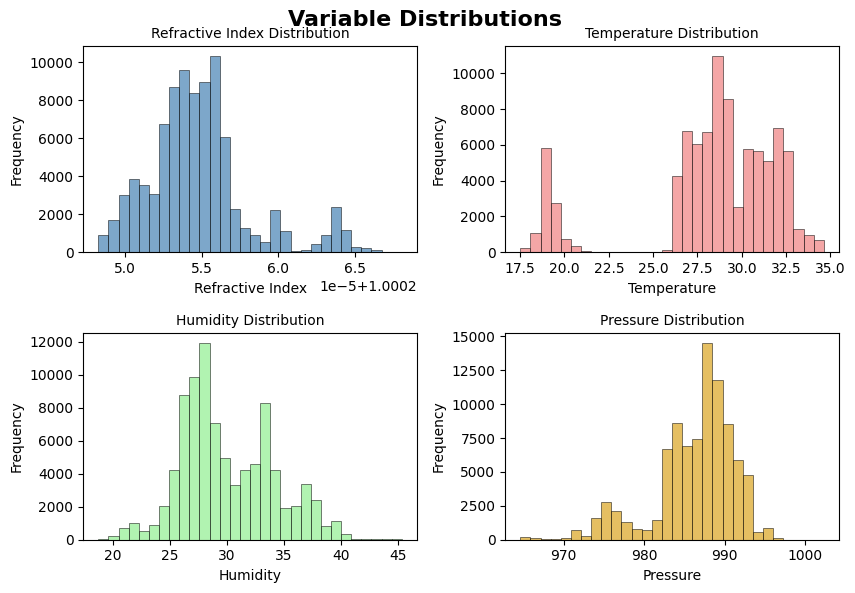

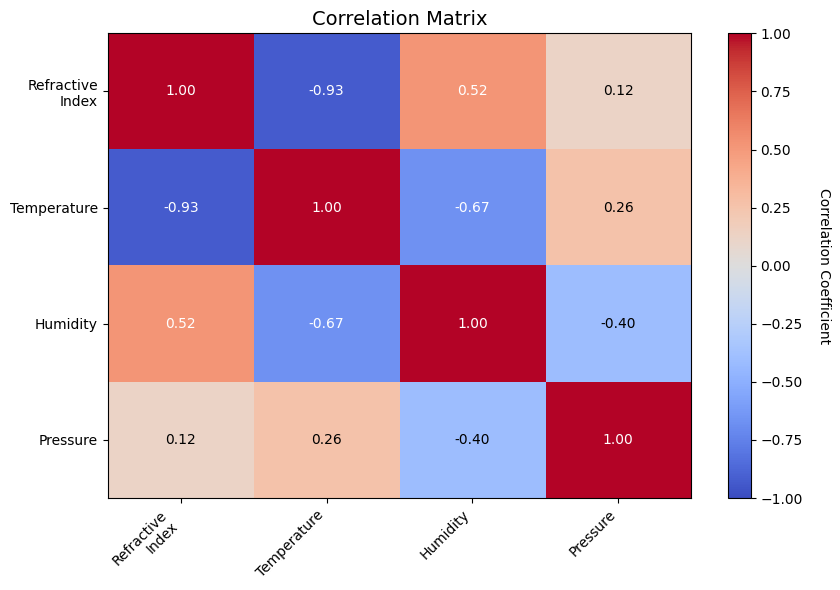

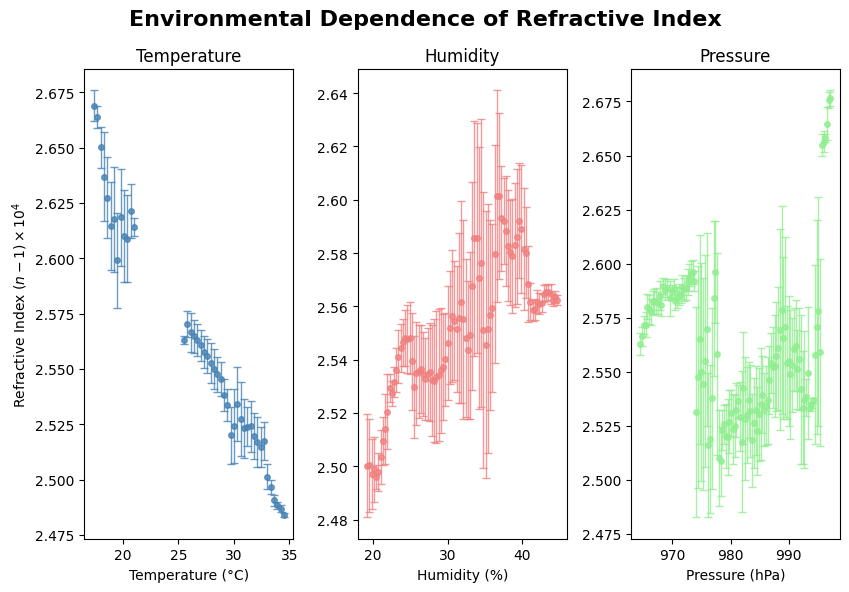

Performing enhanced regression analysis...

1. Basic OLS Results:
                            OLS Regression Results                            
Dep. Variable:                 n_1762   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 7.530e+06
Date:                Sat, 01 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:07:33   Log-Likelihood:             1.2431e+06
No. Observations:               89106   AIC:                        -2.486e+06
Df Residuals:                   89102   BIC:                        -2.486e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

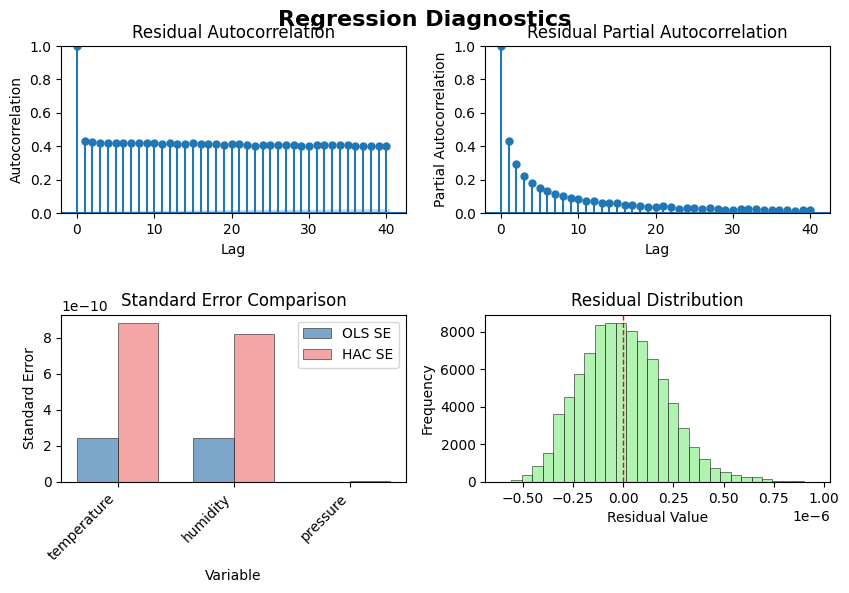

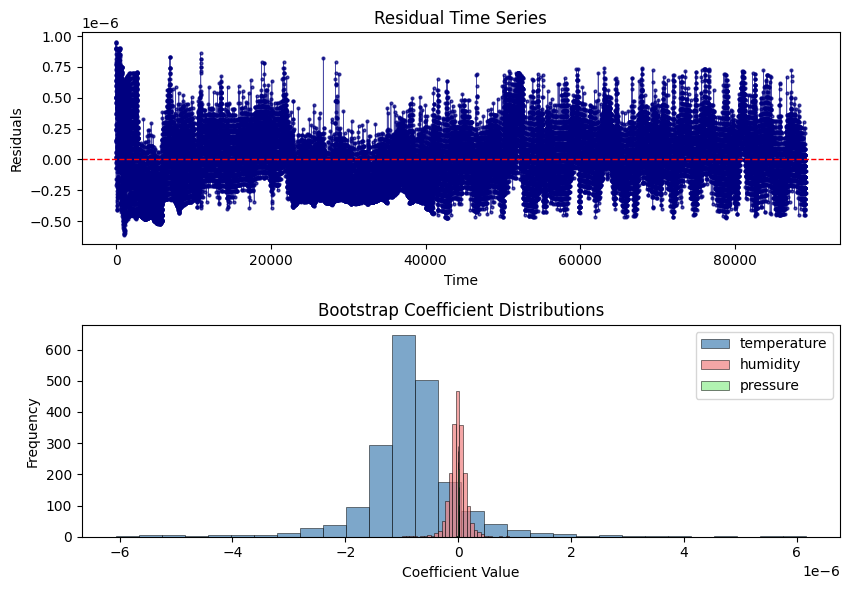

Uncertainty Budget Analysis
Uncertainty Source                 Affected Parameter Estimation Method      Magnitude (1σ)
Finite sample & serial correlation  All coefficients   HAC + Block Bootstrap   5.71e-10    
    Temperature sensor calibration        $\alpha_T$         EIV Monte Carlo   1.72e-10    
       Humidity sensor calibration        $\alpha_H$         EIV Monte Carlo   1.80e-10    
       Pressure sensor calibration        $\alpha_P$         EIV Monte Carlo   1.11e-12    
        780 nm frequency reference     Constant term  Analytical propagation      <1e-9    
       1762 nm frequency reference     Constant term  Analytical propagation Negligible    
      Interferometer non-linearity  All coefficients    Upper-bound estimate Negligible    
         Spatial/temporal mismatch Residual variance       Residual analysis   2.11e-07    

Analysis completed!
All figures saved.


In [2]:
# Load datasets
df1 = pd.read_csv('../data/dataset_20250101_20250310.csv')
df2 = pd.read_csv('../data/dataset_20250601_20250804.csv')

# Combine datasets
combined_df = pd.concat([df1, df2], ignore_index=True)

# Run quality analysis
results, uncertainty_budget = main_analysis(combined_df)

# Alternative: Call individual functions as needed
# visualize_data(combined_df)
# plot_mean_with_errorbar(combined_df)
# results = perform_regression(combined_df, n_bootstrap=2000)
# plot_diagnostics(results, combined_df)
# create_uncertainty_budget_table(results)

In [3]:
def setup_publication_style(font_size=30):
    """
    Configure matplotlib parameters for publication-quality figures.
    
    Parameters:
    -----------
    font_size : int, optional
        Base font size for all text elements (default: 30)
    """
    plt.rcParams.update({
        # 字体设置
        'font.size': font_size,
        'font.family': 'Helvetica',
        'mathtext.fontset': 'stix',
        
        # 图形设置
        'figure.figsize': [10, 8],
        'figure.dpi': 300,
        
        # 坐标轴设置
        'axes.linewidth': 1.2,
        'axes.labelsize': font_size,
        'axes.grid': True,
        'axes.titlesize': font_size,
        
        # 线条设置
        'lines.linewidth': 2.0,
        'lines.markersize': 6,
        'lines.markeredgewidth': 1,
        
        # 刻度设置
        'xtick.labelsize': font_size,
        'ytick.labelsize': font_size,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.minor.visible': True,
        'ytick.minor.visible': True,
        
        # 图例设置
        'legend.fontsize': font_size,
        'legend.frameon': True,
        'legend.fancybox': True,
        'legend.shadow': False,
        'legend.framealpha': 0.95,
        
        # 保存设置
        'savefig.bbox': 'tight',
        'savefig.dpi': 300,
        'savefig.format': 'pdf'
    })

def plot_bootstrap_coefficient_distributions(results, variables=None, 
                                           save_path='bootstrap_coefficient_distributions.pdf',
                                           font_size=30):
    """
    Create publication-quality plots of bootstrap coefficient distributions.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing regression results with 'bootstrap_params' key
    variables : list, optional
        List of variable names (default: ['Temperature', 'Humidity', 'Pressure'])
    save_path : str, optional
        Path to save the output figure
    font_size : int, optional
        Font size for the plot (default: 30)
        
    Returns:
    --------
    tuple
        (figure_object, statistics_dict)
    """
    # Setup publication style
    setup_publication_style(font_size)
    
    # Set default variables if not provided
    if variables is None:
        variables = ['Temperature', 'Humidity', 'Pressure']
    
    # Extract bootstrap parameters
    bootstrap_params = results['bootstrap_params']
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    
    # Panel labels
    panel_labels = ['(a)', '(b)', '(c)']
    
    # Statistics storage
    statistics = {}
    
    for i, (ax, var, label) in enumerate(zip(axes, variables, panel_labels)):
        # Extract coefficients for this variable (skip constant term at index 0)
        coefficients = bootstrap_params[:, i + 1]
        
        # Calculate statistics
        mean_val = np.mean(coefficients)
        median_val = np.median(coefficients)
        std_val = np.std(coefficients)
        ci_95_lower = np.percentile(coefficients, 2.5)
        ci_95_upper = np.percentile(coefficients, 97.5)
        # ci_68_lower = np.percentile(coefficients, 16)
        # ci_68_upper = np.percentile(coefficients, 84)
        
        # Store statistics
        statistics[var] = {
            'mean': mean_val,
            'median': median_val,
            'std': std_val,
            'ci_95': (ci_95_lower, ci_95_upper),
            # 'ci_68': (ci_68_lower, ci_68_upper)
        }
        
        # Create histogram
        n, bins, patches = ax.hist(coefficients, bins=30, 
                                  color=PUB_GOLD, 
                                  edgecolor=PUB_BLUE, 
                                  linewidth=1.5,
                                  density=True,
                                  alpha=0.8,
                                  zorder=2)
        
        # Add statistical lines
        ax.axvline(mean_val, color=PUB_BLUE, linestyle='--', 
                  linewidth=3, label='Mean', zorder=3)
        ax.axvline(ci_95_lower, color=PUB_PURPLE, linestyle='--', 
                  linewidth=2, label='95\% CI', zorder=3)
        ax.axvline(ci_95_upper, color=PUB_PURPLE, linestyle='--', 
                  linewidth=2, zorder=3)
        
        # # Add 68% confidence interval as shaded region
        # ax.axvspan(ci_68_lower, ci_68_upper, alpha=0.3, 
        #           color=PUB_TEAL, label='68% CI', zorder=1)
        
        # Set labels and formatting
        ax.set_xlabel(f'{var} Coefficient')
        ax.set_ylabel('Density')
        ax.text(0.05, 0.95, label, transform=ax.transAxes, 
               va='top', ha='left', fontsize=font_size)
        
        # Scientific notation for y-axis
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        ax.yaxis.major.formatter._useMathText = True
        
        # Grid and minor ticks
        ax.grid(True, alpha=0.3, linestyle='--', zorder=0)
        ax.minorticks_on()
        
        # Set nice x-axis limits
        # x_range = ci_95_upper - ci_95_lower
        # ax.set_xlim(ci_95_lower - 0.1 * x_range, ci_95_upper + 0.1 * x_range)
    
    # Add legend to the first subplot
    handles, labels = axes[0].get_legend_handles_labels()
    # Remove duplicate labels
    unique_labels = []
    unique_handles = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handle)
    
    # axes[0].legend(unique_handles, unique_labels, 
    #               loc='upper right', framealpha=0.9)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    # Print statistics
    print("=== BOOTSTRAP COEFFICIENT STATISTICS ===")
    for var, stats_dict in statistics.items():
        print(f"\n{var} Coefficient:")
        print(f"  Mean: {stats_dict['mean']:.3e}")
        print(f"  Std: {stats_dict['std']:.3e}")
        # print(f"  68% CI: [{stats_dict['ci_68'][0]:.3e}, {stats_dict['ci_68'][1]:.3e}]")
        print(f"  95% CI: [{stats_dict['ci_95'][0]:.3e}, {stats_dict['ci_95'][1]:.3e}]")
    print("=" * 50)
    
    return fig, statistics

def plot_residual_analysis(model_ols, acf_values, acf_confint, pacf_values, pacf_confint,
                          save_path='residual_autocorrelation.pdf', font_size=22):
    """
    Create publication-quality residual analysis plots.
    
    Parameters:
    -----------
    model_ols : statsmodels regression model
        Fitted OLS model
    acf_values : array-like
        Autocorrelation function values
    acf_confint : array-like
        ACF confidence intervals
    pacf_values : array-like
        Partial autocorrelation function values  
    pacf_confint : array-like
        PACF confidence intervals
    save_path : str, optional
        Path to save the output figure
    font_size : int, optional
        Font size for the plot (default: 22)
        
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure object
    """
    # Setup publication style
    setup_publication_style(font_size)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # Panel (a): Residual distribution
    residuals = model_ols.resid
    ax1.hist(residuals, bins=30, color=PUB_GOLD, 
             edgecolor='black', alpha=0.8)
    ax1.axvline(x=0, color=PUB_BLUE, linewidth=2)
    ax1.set_xlabel('Residual Value')
    ax1.set_ylabel('Frequency')
    ax1.text(0.05, 0.95, '(a)', transform=ax1.transAxes, 
             va='top', ha='left', fontsize=font_size)
    
    # Panel (b): ACF and PACF
    lags = np.arange(len(acf_values))
    
    # Plot ACF
    ax2.plot(lags, acf_values, color=PUB_PURPLE, 
             marker='D', markersize=6, markeredgecolor='white', 
             markeredgewidth=1, label='ACF', zorder=3)
    
    # Plot PACF
    ax2.plot(lags, pacf_values, color=PUB_BLUE, linewidth=1.8, 
             marker='^', markersize=7, markeredgecolor='white', 
             markeredgewidth=1, label='PACF', zorder=3)
    
    # Add confidence intervals
    ax2.fill_between(lags, acf_confint[:, 0], acf_confint[:, 1], 
                     color=PUB_PURPLE, alpha=0.15)
    ax2.fill_between(lags, pacf_confint[:, 0], pacf_confint[:, 1], 
                     color=PUB_BLUE, alpha=0.15)
    
    # Add zero reference line
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    
    # Formatting
    ax2.set_xlabel('Lag')
    ax2.set_ylabel('Correlation')
    ax2.set_ylim(-0.1, 1.0)  # Extended to show negative correlations
    ax2.set_xlim(-0.5, len(lags) - 0.5)
    ax2.text(0.05, 0.95, '(b)', transform=ax2.transAxes, 
             va='top', ha='left', fontsize=font_size)
    
    # Add legend
    ax2.legend(loc='upper right', frameon=True, fancybox=True)
    
    # Apply scientific notation and formatting to both subplots
    for ax in [ax1, ax2]:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        ax.yaxis.major.formatter._useMathText = True
        ax.grid(True, alpha=0.3, linestyle='--', zorder=0)
        ax.minorticks_on()
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    return fig

=== BOOTSTRAP COEFFICIENT STATISTICS ===

Temperature Coefficient:
  Mean: -8.368e-07
  Std: 8.950e-07
  95% CI: [-2.669e-06, 9.637e-07]

Humidity Coefficient:
  Mean: -1.247e-08
  Std: 1.464e-07
  95% CI: [-2.876e-07, 2.860e-07]

Pressure Coefficient:
  Mean: 2.425e-09
  Std: 4.563e-09
  95% CI: [-6.987e-09, 1.103e-08]


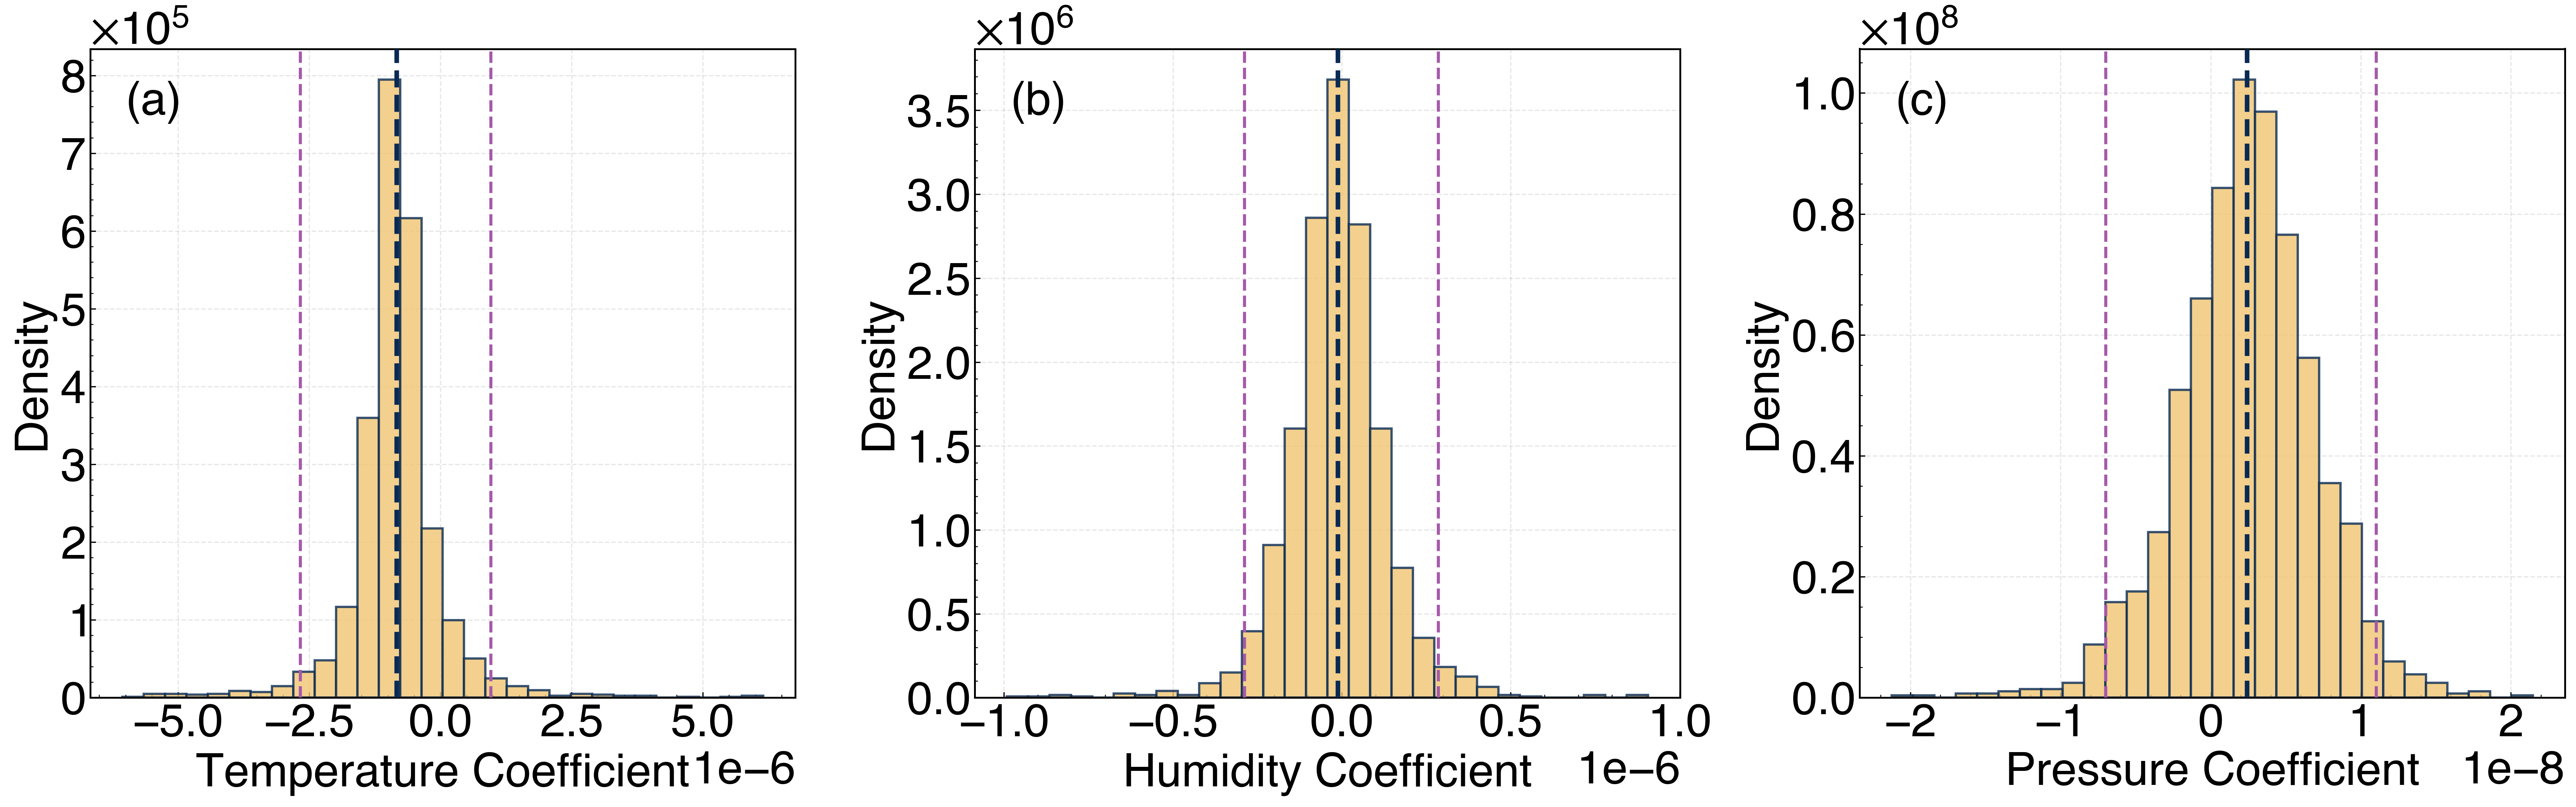

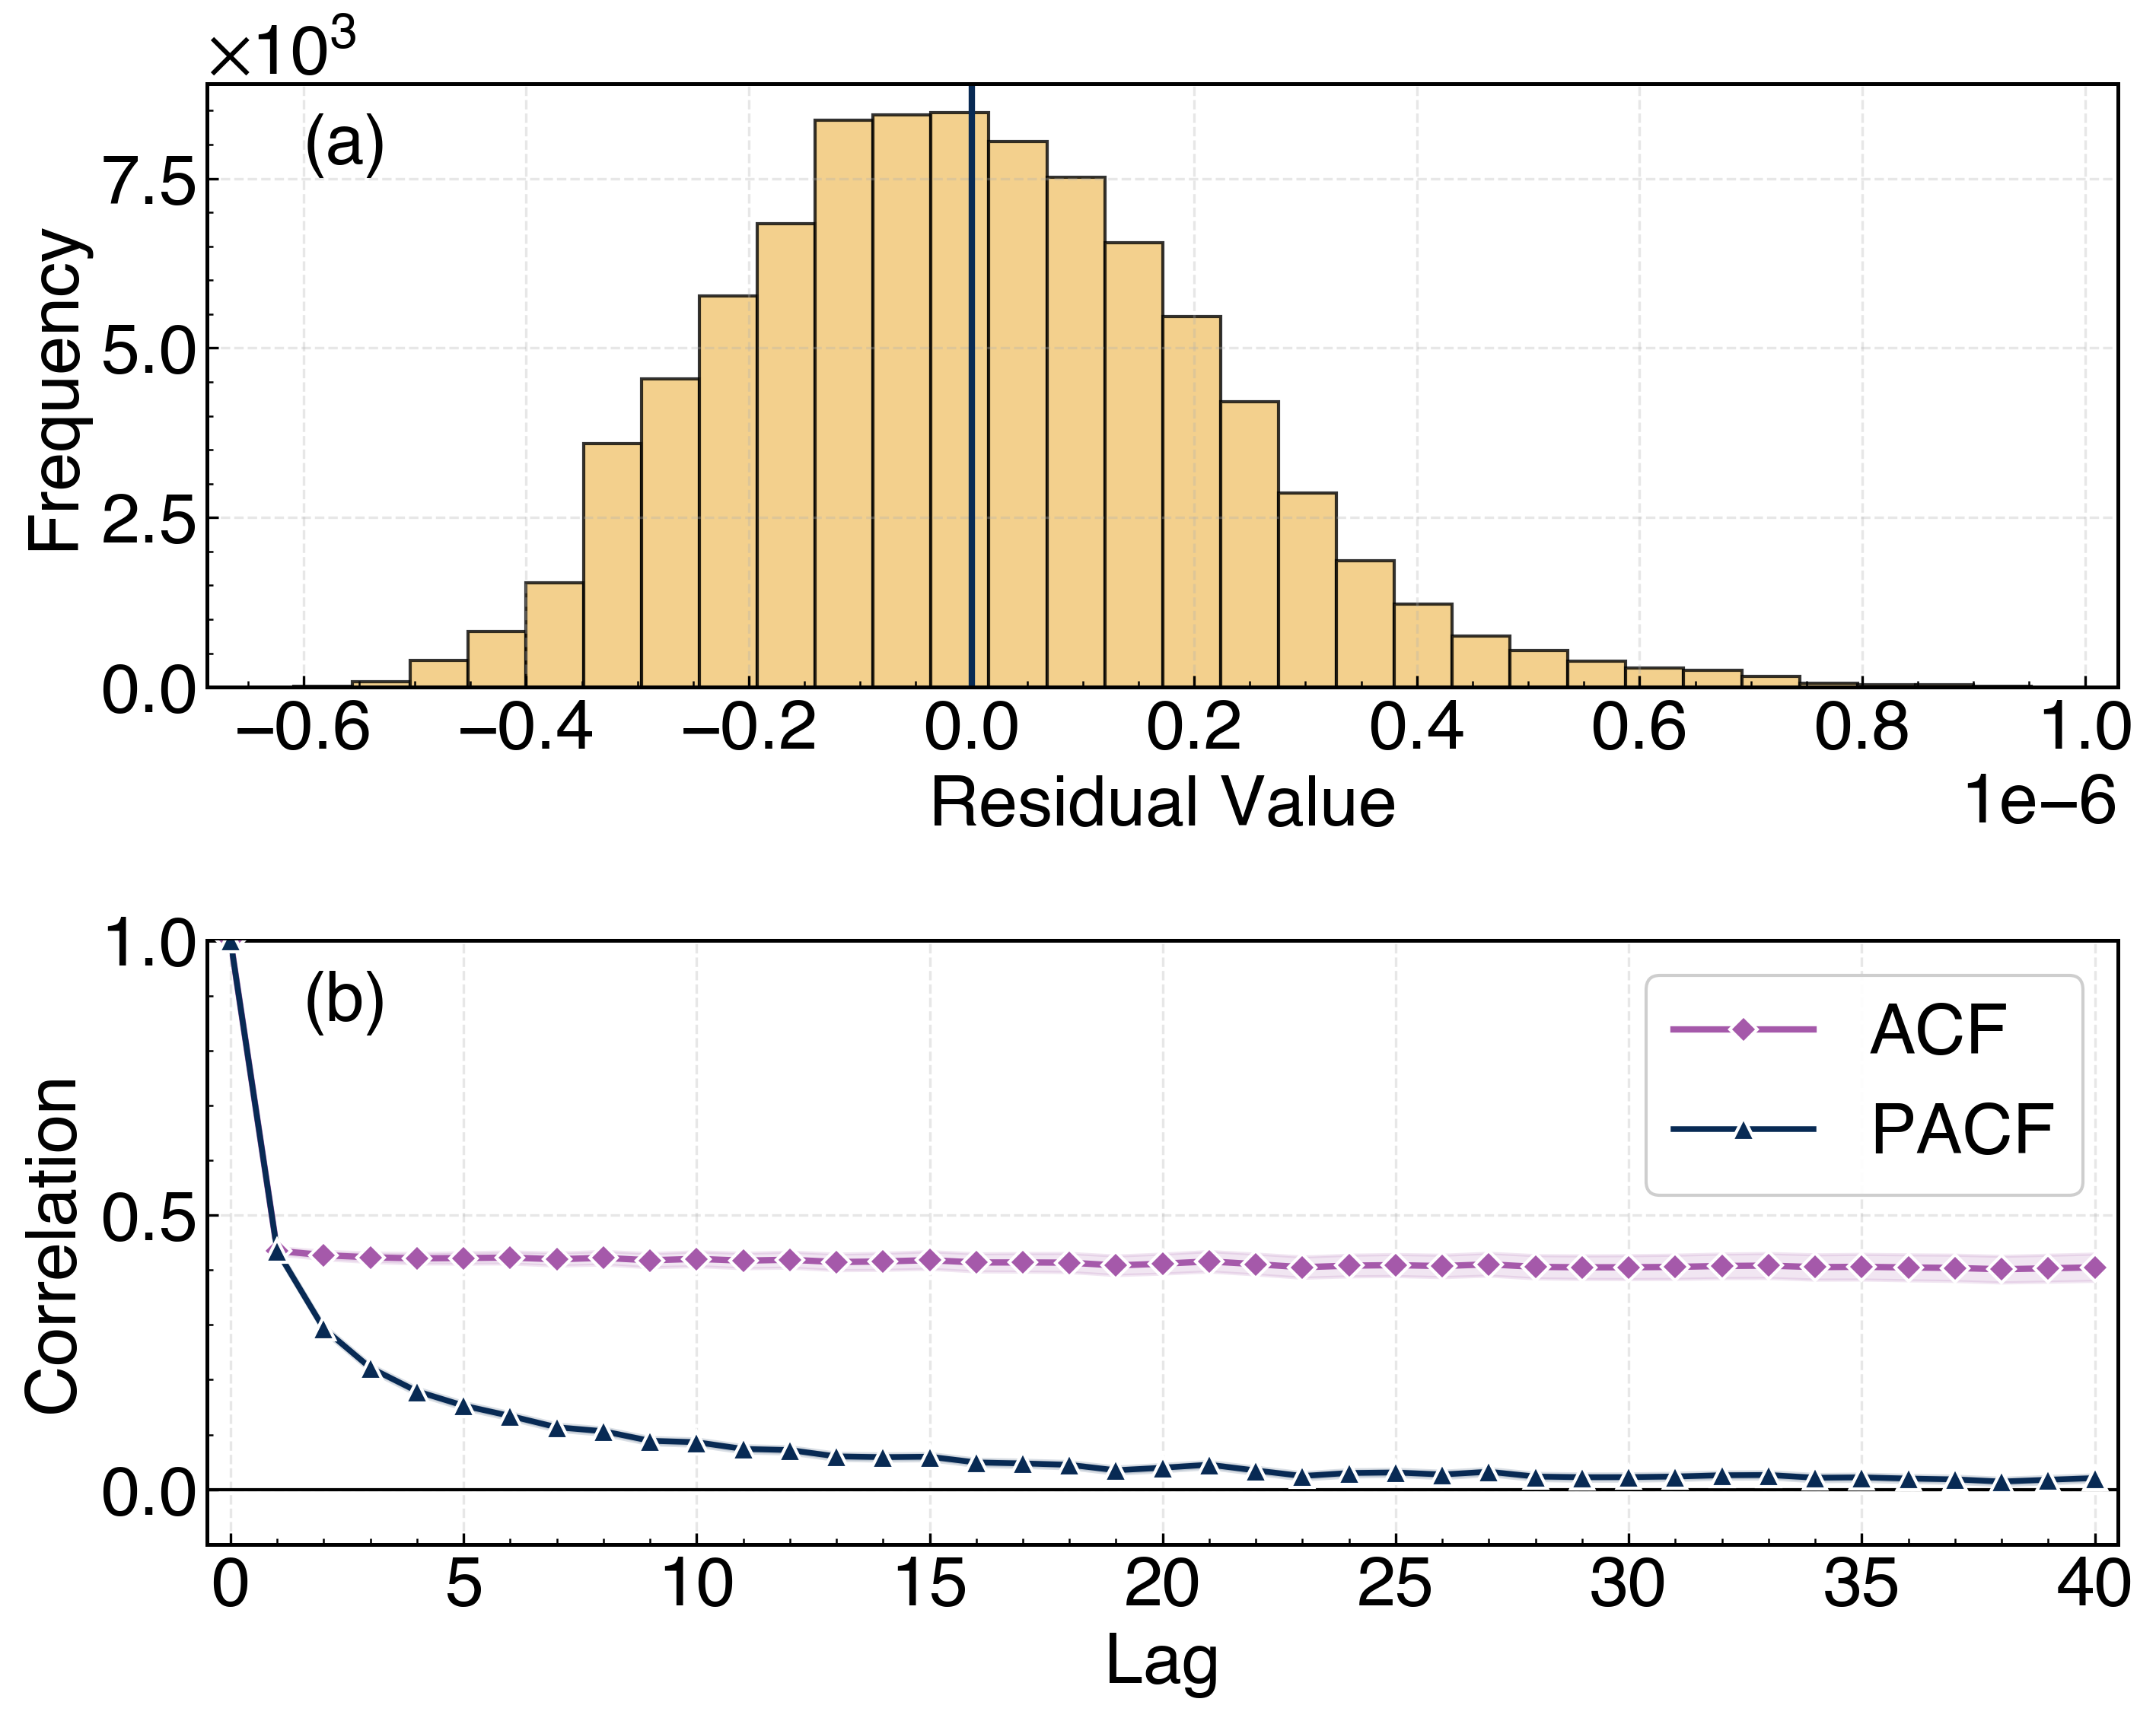

In [4]:
model_ols = results['ols_model']
acf_values, acf_confint = sm.tsa.acf(model_ols.resid, nlags=40, alpha=0.05, fft=False)
pacf_values, pacf_confint = sm.tsa.pacf(model_ols.resid, nlags=40, alpha=0.05)

# Plot bootstrap coefficient distributions
fig1, stats1 = plot_bootstrap_coefficient_distributions(
    results, 
    variables=['Temperature', 'Humidity', 'Pressure'],
    save_path='../figures/bootstrap_coefficient_distributions.pdf',
    font_size=30
)

# Plot residual analysis
fig2 = plot_residual_analysis(
    model_ols, acf_values, acf_confint, pacf_values, pacf_confint,
    save_path='../figures/residual_autocorrelation.pdf',
    font_size=22
)

plt.show()